# TODO:

*   Pass tokenizer as function parameter (instead of calling global)



# Setup

In [54]:
!pip install -q tf-models-official==2.3.0
!pip install transformers

In [55]:
import os
import json, pickle

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import transformers
from transformers import BertTokenizer, TFBertModel
transformers.logging.set_verbosity_error() # suppress tokenizer sentences' length warnings so to not disturbate rou beautiful loading bar oh my gosh

from keras import Model
from keras.utils import plot_model
from keras.layers import Input, Dense, Flatten, Dropout
from datetime import datetime

from google.colab import drive, files

In [56]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Settings


In [57]:
### PARAMETERS ###
RANDOM_STATE = 42

# Dataset creation
SEQUENCE_LIMIT = 512
STRIDE = 256

SHUFFLE = True

TRAIN_LIMIT = 1000  # set None for the full size
VAL_LIMIT = 500    # set None for the full size
TEST_LIMIT = 500   # set None for the full size

# Model Training
EPOCHS = 1
BATCH_SIZE = 6

# dataset drive settings
SAVE_DATASET = True
LOAD_DATASET = False

# model weights drive settings
SAVE_WEIGHTS = True
LOAD_WEIGHTS = False

# Dataset

In [58]:
try:
  with open('training_set.json') as f:
    json_data = json.load(f)
except:
  with open('/content/drive/My Drive/SQUAD/training_set.json') as f:
    json_data = json.load(f)

In [59]:
# Creates DataFrames with useful columns by unpacking 'paragraphs' column
def unpack_df(df):
  temp = []
  title_dict = {}
  contexts = []

  for i, row in df.iterrows():
    for context in row['paragraphs']:
      contexts.append(context['context'])
      for qa in context['qas']:
        question_id = qa['id']
        question = qa['question']
        for answer in qa['answers']:
          answer_text = answer['text']
          answer_start = answer['answer_start']
          answer_end = answer_start+len(answer_text)
          temp.append([question_id, question, answer_text, answer_start, answer_end, i, len(contexts)-1])

  context_dict = dict(enumerate(contexts))
  df = pd.DataFrame(temp, columns=['question_id', 'question_text', 'answer_text', 'answer_start', 'answer_end', 'title_id', 'context_id'])
  
  return df, context_dict

# Read data from json
data = pd.json_normalize(json_data['data'])

# Split train and test
train_val, test = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)
train, val = train_test_split(train_val, test_size=0.25, random_state=RANDOM_STATE)

# Create DataFrames with useful columns
train_df, train_context_dict = unpack_df(train)
val_df, val_context_dict = unpack_df(val)
test_df, test_context_dict = unpack_df(test)

# Shuffle DataFrame
if SHUFFLE:
  train_df = train_df.sample(frac = 1)
  val_df = val_df.sample(frac = 1)
  test_df = test_df.sample(frac = 1)

train_df

,question_id,question_text,answer_text,answer_start,answer_end,title_id,context_id
43157,5728c068ff5b5019007da5fb,In what city was the French Academy of Science...,Paris,158,163,327,9378
5957,56df25da3277331400b4d9af,In what year did Sony take BMG's half stake in...,2008,13,17,50,1358
32599,5725b777ec44d21400f3d447,Who form the largest group of Chinese in Indon...,Hokkien speakers,649,665,189,7105
420,572b88b934ae481900deae7d,What did the FDA order removed from stores in ...,zinc-based intranasal cold products,324,359,337,91
11855,56f6f4703d8e2e1400e372e0,Instrument currently used in most classical mu...,the mid-19th century,84,104,83,2659
...,...,...,...,...,...,...,...
14663,572e9b93cb0c0d14000f134a,Which angel is believed to have communicated t...,Gabriel,85,92,375,3257
27977,56d62ff01c85041400946fb2,What are conformation shows also known as?,breed shows,43,54,20,6162
3685,572947c26aef051400154c63,Why does a third of the population spend time ...,seafaring the only real industry,572,604,256,802
34606,57337fd34776f41900660bfb,How many of the richest families had a decreas...,77,392,394,23,7566


In [60]:
# Inspect data samples
def print_squad_sample(train_data, context_dict, line_length=120, separator_length=150):

  sample = train_data.sample(frac=1).head(1)
  context = context_dict[sample['context_id'].item()]

  print('='*separator_length, '\nCONTEXT:\n', '='*separator_length)

  lines = [''.join(context[idx:idx+line_length]) for idx in range(0, len(context), line_length)]
  for l in lines:
      print(l)

  print('='*separator_length, '\nQUESTION:', ' '*(3*separator_length//4), 'ANSWER:')

  questions = train_data[train_data['context_id'] == sample['context_id'].item()]

  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), answer)

print_squad_sample(train_df, train_context_dict)

CONTEXT:
The University of Kansas School of Architecture, Design, and Planning (SADP), with its main building being Marvin Hall, 
traces its architectural roots to the creation of the architectural engineering degree program in KU's School of Enginee
ring in 1912. The Bachelor of Architecture degree was added in 1920. In 1969, the School of Architecture and Urban Desig
n (SAUD) was formed with three programs: architecture, architectural engineering, and urban planning. In 2001 architectu
ral engineering merged with civil and environmental engineering. The design programs from the discontinued School of Fin
e Arts were merged into the school in 2009 forming the current School of Architecture, Design, and Planning.
QUESTION:                                                                                                                  ANSWER:
What was the name of the school that served as the SADP's precursor?                                                       the School of Architect

## Tokenizer

In [61]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

print('[[CLS], [SEP]] = {}'.format(tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])))

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(train_df['question_text'][0])

# Print out the tokens.
print('\nTokenized sentence:')
print(tokenized_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indices.
print('\n{:<12} {:>6}\n'.format('TOKENS', 'INDICES'))
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6}'.format(tup[0], tup[1]))

[[CLS], [SEP]] = [101, 102]

Tokenized sentence:
['where', 'does', 'migration', 'mainly', 'occur', '?']

TOKENS       INDICES

where          2073
does           2515
migration      9230
mainly         3701
occur          5258
?              1029


## Prepare data for model

In [62]:
# Prints COOL progress bar (No, seriously, it's really cool!)
# REALLY DUDE, THIS STUFF IS GOLD
def print_progress(value, total, bar_width=100):
  perc = int(value/total*bar_width)
  rest = bar_width - perc
  print("\r{:>3} % [ {}{} ]".format(perc, perc*'■', rest*'─'), end="")

# ensure to preserve all sub-sequences of length limi-stride. 
def split_long_sequence(my_sequence, limit, stride):

  if len(my_sequence) <= limit: 
    return [my_sequence]
  
  rest = my_sequence
  split = []
  while len(rest) > limit:
    left_hand = rest[:limit]
    rest = rest[stride:]
    split.append(left_hand)
    
  split.append(rest)
  return split

# Returns start and end indices of sublist in list
def find_sublist(a, b):
  if len(a) == 0 or len(b) == 0:
    raise Exception("Lists with length 0")
    
  for i in range(len(a) - len(b) +1):
    if np.array_equal(a[i:i+len(b)], b):
      return i, i+len(b)-1
  return -1, -1

In [63]:
def from_df_to_model_dict(df, context_dict, verbose=False):

  # initialize structures
  question_id = []
  question_text = []
  context_id = []
  answer_text = []
  input_ids = []
  input_mask = []
  input_type_ids = []
  start_indexes = []
  end_indexes = []

  cut_counter = 0
  max_iter = len(df)
  new_entries = 0
  for i, (_, row) in enumerate(df.iterrows()):

    # print progress
    if (i+1) % (max_iter // 100) == 0 or i == 0:
      print_progress(i+1, max_iter)

    # encode question and context
    if verbose: print("\tTokenizing question and context...", end="")
    encoded_question = tokenizer.encode(row['question_text'])
    encoded_context = tokenizer.encode(context_dict[row['context_id']])[1:]

    # concatenate input data 
    if verbose: print("\tChecking sequence length...")
    if len(encoded_question + encoded_context) > SEQUENCE_LIMIT:
      # if the sequence is too long, split it in n subsequences of length <= SEQUENCE_LIMIT
      encoded_contexts = split_long_sequence(encoded_context,
                                             limit=SEQUENCE_LIMIT-len(encoded_question), 
                                             stride=STRIDE)
      cut_counter += 1
    else:
      encoded_contexts = [encoded_context]
    
    new_entries += len(encoded_contexts)-1
    # for each too long sequence, the context has been split in n parts. We need to process them separately, creating new entries for the input
    for context_piece in encoded_contexts:
      
      encoded_input = encoded_question + context_piece

      # create mask of ones
      ones_mask = tf.ones_like(encoded_input)

      # add padding and convert to tensor
      if verbose: print("\tPadding...", end="")
      encoded_input = tf.keras.preprocessing.sequence.pad_sequences([encoded_input], maxlen=512, padding='pre')
      encoded_input = tf.squeeze(tf.convert_to_tensor(encoded_input))

      # processing answer indices
      if verbose: print("\tProcessing answer...", end="")
      tokenized_answer = tokenizer.encode(row['answer_text'])[1: -1]
      start_idx, end_idx = find_sublist(encoded_input, tokenized_answer)

      start_indexes.append(start_idx)
      end_indexes.append(end_idx)


      # create input_type_ids
      if verbose: print("\tInput types creation...", end="")
      type_ids = tf.concat([tf.zeros_like(encoded_question, dtype=tf.int32), 
                            tf.ones_like(context_piece, dtype=tf.int32)], 
                          axis=-1)
      
      type_ids = tf.keras.preprocessing.sequence.pad_sequences([type_ids], maxlen=512, padding='pre')
      type_ids = tf.squeeze(tf.convert_to_tensor(type_ids))


      # create mask of zeros
      if verbose: print("\tMask creation...", end="")
      zeros_mask = tf.zeros(SEQUENCE_LIMIT - len(ones_mask), dtype=tf.int32)
      mask = tf.concat([zeros_mask, ones_mask], axis=-1)

      # append elements to lists
      if verbose: print("\tAppending inputs...", end="")
      question_id.append(row['question_id'])
      question_text.append(row['question_text'])
      context_id.append(row['context_id'])
      answer_text.append(row['answer_text'])
      input_ids.append(encoded_input)
      input_mask.append(mask)
      input_type_ids.append(type_ids)

  # save input data as dictionary
  data = {
    'question_id': question_id,
    'question_text': question_text,
    'answer_text': answer_text,
    'context_id': context_id,
    'input_ids': tf.convert_to_tensor(input_ids),
    'attention_mask': tf.convert_to_tensor(input_mask),
    'token_type_ids': tf.convert_to_tensor(input_type_ids),
    'start_idx': start_indexes,
    'end_idx': end_indexes,
    }

  assert len(input_ids) == len(df) + new_entries, f"ATTENTION:\nci sono {len(input_ids)} input_ids, MA {len(df)} righe nel df e {new_entries} nuove entries"
  return data

# Building Dataset

In [64]:
if not LOAD_DATASET:
  print("Building training set...")
  train = from_df_to_model_dict(train_df[:TRAIN_LIMIT], train_context_dict)

  print("\n\nBuilding validation set...")
  val = from_df_to_model_dict(val_df[:VAL_LIMIT], val_context_dict)

  print("\n\nBuilding test set...")
  test = from_df_to_model_dict(test_df[:TEST_LIMIT], test_context_dict)

Building training set...
100 % [ ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ]

Building validation set...
100 % [ ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ]

Building test set...
100 % [ ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ]

# Index to categorical


In [65]:
if not LOAD_DATASET: 
  # Replace -1 (answer not found) with 0
  train['start_idx'] = [val if val != -1 else 0 for val in train['start_idx']]
  train['end_idx'] = [val if val != -1 else 0 for val in train['end_idx']]

  val['start_idx'] = [val if val != -1 else 0 for val in val['start_idx']]
  val['end_idx'] = [val if val != -1 else 0 for val in val['end_idx']]

  test['start_idx'] = [val if val != -1 else 0 for val in test['start_idx']]
  test['end_idx'] = [val if val != -1 else 0 for val in test['end_idx']]

  # from ints to categorical
  train['start_cat'] = tf.keras.utils.to_categorical(train['start_idx'], num_classes=SEQUENCE_LIMIT)
  train['end_cat'] = tf.keras.utils.to_categorical(train['end_idx'], num_classes=SEQUENCE_LIMIT)

  val['start_cat'] = tf.keras.utils.to_categorical(val['start_idx'], num_classes=SEQUENCE_LIMIT)
  val['end_cat'] = tf.keras.utils.to_categorical(val['end_idx'], num_classes=SEQUENCE_LIMIT)

  test['start_cat'] = tf.keras.utils.to_categorical(test['start_idx'], num_classes=SEQUENCE_LIMIT)
  test['end_cat'] = tf.keras.utils.to_categorical(test['end_idx'], num_classes=SEQUENCE_LIMIT)

  # Inspect data
  assert len(train['start_idx']) == len(train['end_idx']) == len(train['input_ids']) == len(train['attention_mask']) == len(train['token_type_ids'])
  assert len(val['start_idx']) == len(val['end_idx']) == len(val['input_ids']) == len(val['attention_mask']) == len(val['token_type_ids'])
  assert len(test['start_idx']) == len(test['end_idx']) == len(test['input_ids']) == len(test['attention_mask']) == len(test['token_type_ids'])

  print("Shapes")
  print("\nTrain starts:\t", train['start_cat'].shape)
  print("Train ends:\t", train['end_cat'].shape)
  print("\nVal starts:\t", val['start_cat'].shape)
  print("Val ends:\t", val['end_cat'].shape)
  print("\nTest starts:\t", test['start_cat'].shape)
  print("Test ends:\t", test['end_cat'].shape)

Shapes

Train starts:	 (1001, 512)
Train ends:	 (1001, 512)

Val starts:	 (500, 512)
Val ends:	 (500, 512)

Test starts:	 (501, 512)
Test ends:	 (501, 512)


# Save data to Drive

In [66]:
if SAVE_DATASET:

  # TRAIN
  with open("/content/drive/MyDrive/SQUAD/train.p", "wb") as f:
    pickle.dump(train, f)
  with open("/content/drive/MyDrive/SQUAD/train_context_dict.p", "wb") as f:
    pickle.dump(train_context_dict, f)

  # VALIDATION
  with open("/content/drive/MyDrive/SQUAD/val.p", "wb") as f:
    pickle.dump(val, f)
  with open("/content/drive/MyDrive/SQUAD/val_context_dict.p", "wb") as f:
    pickle.dump(val_context_dict, f)

  # TEST
  with open("/content/drive/MyDrive/SQUAD/test.p", "wb") as f:
    pickle.dump(test, f)
  with open("/content/drive/MyDrive/SQUAD/test_context_dict.p", "wb") as f:
    pickle.dump(test_context_dict, f)

# Load data from Drive

In [67]:
if LOAD_DATASET:

  # TRAIN
  with open("/content/drive/MyDrive/SQUAD/train.p", "rb") as f:
    train = pickle.load(f)
  with open("/content/drive/MyDrive/SQUAD/train_context_dict.p", "rb") as f:
    train_context_dict = pickle.load(f)

  # VALIDATION
  with open("/content/drive/MyDrive/SQUAD/val.p", "rb") as f:
    val = pickle.load(f)
  with open("/content/drive/MyDrive/SQUAD/val_context_dict.p", "rb") as f:
    val_context_dict = pickle.load(f)

  # TEST
  with open("/content/drive/MyDrive/SQUAD/test.p", "rb") as f:
    test = pickle.load(f)
  with open("/content/drive/MyDrive/SQUAD/test_context_dict.p", "rb") as f:
    test_context_dict = pickle.load(f)

In [68]:
print("Shapes")
print("\nTrain starts:\t", train['start_cat'].shape)
print("Train ends:\t", train['end_cat'].shape)
print("\nVal starts:\t", val['start_cat'].shape)
print("Val ends:\t", val['end_cat'].shape)
print("\nTest starts:\t", test['start_cat'].shape)
print("Test ends:\t", test['end_cat'].shape)

assert train['start_cat'].shape == train['end_cat'].shape
assert val['start_cat'].shape == val['end_cat'].shape
assert test['start_cat'].shape == test['end_cat'].shape

Shapes

Train starts:	 (1001, 512)
Train ends:	 (1001, 512)

Val starts:	 (500, 512)
Val ends:	 (500, 512)

Test starts:	 (501, 512)
Test ends:	 (501, 512)


# Build model

In [69]:
from keras.layers import Dropout, Activation

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 109482240   input_4[0][0]                    
                                                                 input_5[0][0]              

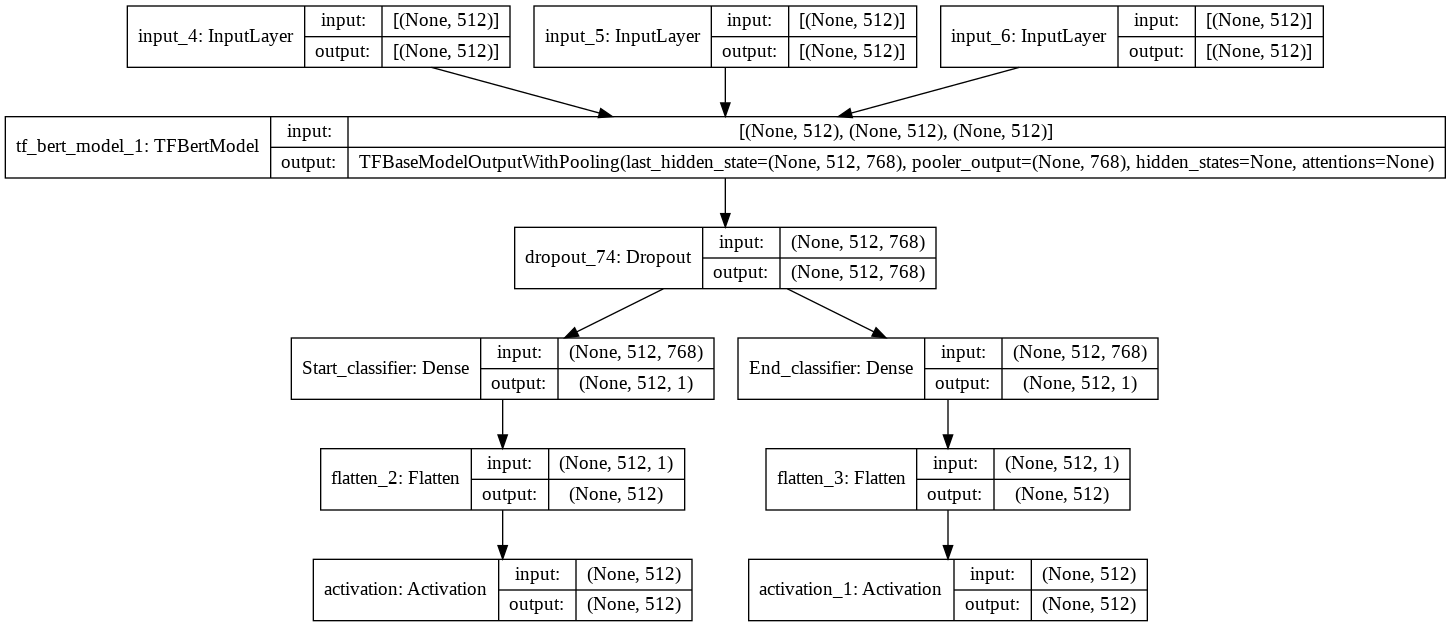

In [70]:
@tf.autograph.experimental.do_not_convert
def build_model():

  # Define Input layers
  input_ids_layer = Input(shape = (512,), dtype='int64')
  attention_mask_layer = Input(shape = (512,), dtype='int64')
  token_ids_layer = Input(shape = (512,), dtype='int64')

  # Load Bert model
  bert_model = TFBertModel.from_pretrained('bert-base-uncased')
  
  bert_model.trainable = True
  
  # Initialize bert model
  bert = bert_model([input_ids_layer,
                    attention_mask_layer,
                    token_ids_layer],
                    return_dict = False,
                    output_attentions = False,
                    output_hidden_states = False
                    ).last_hidden_state
  
  # Dropout
  dropout = Dropout(0.2)(bert)

  # Classifiers
  start_classifier = Dense(units=1, name="Start_classifier")(dropout)
  end_classifier = Dense(units=1, name="End_classifier")(dropout)

  # Flatteners
  start_flat = Flatten()(start_classifier)
  end_flat = Flatten()(end_classifier)

  # Activations
  start_softmax = Activation(tf.keras.activations.softmax)(start_flat)
  end_softmax = Activation(tf.keras.activations.softmax)(end_flat)

  # Build model
  model = Model(inputs=[input_ids_layer, attention_mask_layer, token_ids_layer], 
                outputs=[start_softmax, end_softmax])
  
  model.summary()
  return model

model = build_model()
plot_model(model, show_shapes=True)

# Train

In [71]:
# Define model parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08
                                     #, clipnorm=1.0
                                     )
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [72]:
def print_train_progress(value, total, outputs, bar_width=100):
  perc = int(value/total*bar_width)
  rest = bar_width - perc
  print("\r{:>3} % [ {}{} ] start_loss: {} end_loss: {} start_accuracy: {} end_accuracy: {}".format(perc, perc*'■', rest*'─', outputs[1], outputs[2], outputs[3], outputs[4]), end="")

In [73]:
# Fit model in batches
batches_for_epoch = len(train['input_ids'])//BATCH_SIZE

if LOAD_WEIGHTS:
  model.load_weights('/content/drive/MyDrive/SQUAD/weights.h5')
  
for i in range(EPOCHS):
  for j in range(batches_for_epoch):

    batch_start = j*BATCH_SIZE
    batch_end = j*BATCH_SIZE + BATCH_SIZE

    outputs = model.train_on_batch(x = [train['input_ids'][batch_start : batch_end],
                                        train['attention_mask'][batch_start : batch_end],
                                        train['token_type_ids'][batch_start : batch_end]],
                                    y = (np.array(train['start_idx'][batch_start : batch_end], dtype=np.float32),
                                        np.array(train['end_idx'][batch_start : batch_end], dtype=np.float32)))
    
    print_train_progress(j, batches_for_epoch, outputs)

  if SAVE_WEIGHTS:
    model.save_weights('/content/drive/MyDrive/SQUAD/weights.h5')

 99 % [ ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■─ ] start_loss: 2.372654676437378 end_loss: 1.557212233543396 start_accuracy: 0.3333333432674408 end_accuracy: 0.5

In [74]:
# # Fit model with train set
# model_fit = model.fit(x = [train['input_ids'][:TRAIN_LIMIT],
#                            train['attention_mask'][:TRAIN_LIMIT],
#                            train['token_type_ids'][:TRAIN_LIMIT]],
#                       y = (np.array(train['start_idx'][:TRAIN_LIMIT], dtype=np.float32),
#                            np.array(train['end_idx'][:TRAIN_LIMIT], dtype=np.float32)),
                       
#                       batch_size = BATCH_SIZE,
                       
#                       epochs = EPOCHS, 
                      
#                       validation_data=([val['input_ids'][:VAL_LIMIT],
#                                         val['attention_mask'][:VAL_LIMIT],
#                                         val['token_type_ids'][:VAL_LIMIT]],
#                                         (np.array(val['start_idx'][:VAL_LIMIT], dtype=np.float32),
#                                          np.array(val['end_idx'][:VAL_LIMIT], dtype=np.float32))
#                                        )
#                       )

# Test

In [75]:
# Predict test set
pred = model.predict([test["input_ids"][:TEST_LIMIT], 
                      test["attention_mask"][:TEST_LIMIT], 
                      test["token_type_ids"][:TEST_LIMIT]])

pred_start_ids = np.argmax(pred[0], axis=-1)
pred_end_ids = np.argmax(pred[1], axis=-1)

In [104]:
start_acc =  accuracy_score(test['start_idx'][:TEST_LIMIT], pred_start_ids)
start_f1 = f1_score(test['start_idx'][:TEST_LIMIT], pred_start_ids, average="macro")
end_acc = accuracy_score(test['end_idx'][:TEST_LIMIT], pred_end_ids)
end_f1 = f1_score(test['end_idx'][:TEST_LIMIT], pred_end_ids, average="macro")

print("test start accuracy:", start_acc)
print("test start f1-score:", start_f1, '\n')

print("test end accuracy:", end_acc)
print("test end f1-score:", end_f1)

test start accuracy: 0.426
test start f1-score: 0.32138437320255503 

test end accuracy: 0.476
test end f1-score: 0.3549736069231483


In [92]:
def get_text_from_token_ids(context, start_id, end_id):
  return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(context[start_id:end_id+1]))

boom_baby = 0
for i, _ in enumerate(test['input_ids'][:TEST_LIMIT]):

  true_answer = test['answer_text'][i]
  predicted_answer = get_text_from_token_ids(test['input_ids'][i], pred_start_ids[i], pred_end_ids[i])

  if pred_start_ids[i] == test['start_idx'][i] and pred_end_ids[i] == test['end_idx'][i]: boom_baby += 1

  if i % 100 == 0:
    print("\n\nQuestion: \n", test["question_text"][i])
    print("Context: \n", test_context_dict[test["context_id"][i]])

    print(f"True answer: \n\tids {(test['start_idx'][i], test['end_idx'][i])}\t\ttext: {test['answer_text'][i]}")
    print(f"Our answer: \n\tids {(pred_start_ids[i], pred_end_ids[i])}\t\ttext: {predicted_answer}")

    print("\n", "-"*50)



Question: 
 In what structure was Eisenhower's headquarters in the US Occupation Zone?
Context: 
 Following the German unconditional surrender, Eisenhower was appointed Military Governor of the U.S. Occupation Zone, based at the IG Farben Building in Frankfurt am Main. He had no responsibility for the other three zones, controlled by Britain, France and the Soviet Union, except for the city of Berlin, which was managed by the Four-Power Authorities through the Allied Kommandatura as the governing body. Upon discovery of the Nazi concentration camps, he ordered camera crews to document evidence of the atrocities in them for use in the Nuremberg Trials. He reclassified German prisoners of war (POWs) in U.S. custody as Disarmed Enemy Forces (DEFs), who were no longer subject to the Geneva Convention. Eisenhower followed the orders laid down by the Joint Chiefs of Staff (JCS) in directive JCS 1067, but softened them by bringing in 400,000 tons of food for civilians and allowing more frat

In [102]:
print(f"Exact matches\t{boom_baby} / {TEST_LIMIT} \t({(boom_baby / TEST_LIMIT)*100} %)")

Exact matches	148 / 500 	(29.599999999999998 %)


In [143]:
time = datetime.now().strftime("%d-%m-%Y_%H:%M")

with open(f"/content/drive/MyDrive/SQUAD/results_{time}.txt", "w") as f:

  f.write(f"TEST start accuracy: {start_acc}")
  f.write(f"\nTEST start f1-score: {start_f1}")

  f.write(f"\n\nTEST end accuracy: {end_acc}")
  f.write(f"\nTEST end f1-score: {end_f1}")

  f.write("\n\nTest exact matches: {}/{} ({:.2f}%)".format(boom_baby, TEST_LIMIT, (boom_baby/TEST_LIMIT)*100) )

In [144]:
with open(f"/content/drive/MyDrive/SQUAD/results_{time}.txt", "r") as f:
  for line in f.readlines():
    print(line, end="")

TEST start accuracy: 0.426
TEST start f1-score: 0.32138437320255503

TEST end accuracy: 0.476
TEST end f1-score: 0.3549736069231483

Test exact matches: 148/500 (29.60%)